In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import torch.nn.functional as F

from torchinfo import summary

import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter


In [29]:
class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(160 * 120, 2056)
        self.fc2 = nn.Linear(2056, 1028)
        self.fc3 = nn.Linear(1028, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 160 * 120)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(76800, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Reshape for fully connected layer
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
class LightweightCNN(nn.Module):
    def __init__(self):
        super(LightweightCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)

        # Reshape for fully connected layer
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    

# Creating a CNN class
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(63936, 1024)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [30]:
model = LightweightCNN()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [31]:
# Import training and validation dataset from npz file
with np.load('/Users/jvelasquez/Virginia_Tech/Spring_2023/ECE_4806/ieee-robotics-2023-code/src/jetson_code/pedestal_classification/pedestal_color_orientation_dataset.npz') as data:
    print(data.files)
    images = data['images']
    labels = data['labels']

# Preprocess the images
images = images.astype('float32') / 255
print(images[0].shape)

# Make labels shape (n, 1)
#labels.reshape(labels.shape[0], 1)

# Convert the numpy arrays to PyTorch tensors
images_tensor = torch.from_numpy(images)
labels_tensor = torch.from_numpy(labels)

# Load the testing set
with np.load('/Users/jvelasquez/Virginia_Tech/Spring_2023/ECE_4806/ieee-robotics-2023-code/src/jetson_code/pedestal_classification/pedestal_color_orientation_test_dataset.npz') as data:
    print(data.files)
    test_images = data['images']
    test_labels = data['labels']

test_images = test_images.astype('float32') / 255
#test_labels = test_labels.reshape(test_labels.shape[0], 1)

# Shuffle test_images and test_labels together
p = np.random.permutation(len(test_images))
test_images = test_images[p]
test_labels = test_labels[p]

# Convert the numpy arrays to PyTorch tensors
test_images_tensor = torch.from_numpy(test_images)
test_labels_tensor = torch.from_numpy(test_labels)


['images', 'labels']
(3, 120, 160)
['images', 'labels']


In [32]:
# Define the dataset using the tensors
dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)

# Take a portion of the the test images and labels and append them to the dataset
portion = int(len(test_images_tensor) * 0.75)
dataset = torch.utils.data.ConcatDataset([dataset, torch.utils.data.TensorDataset(test_images_tensor[:portion], test_labels_tensor[:portion])])

# Take the other portion of the test images and labels and use them as the test set
other_portion = int(len(test_images_tensor) - portion)
test_set = torch.utils.data.TensorDataset(test_images_tensor[other_portion:], test_labels_tensor[other_portion:])

# Define image transformations
# Define the image transformations
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ToTensor()
# ])

# Split the dataset into training, validation, and testing sets
train_split = 0.8
train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# # Apply transformations to all images in the training set
# train_transformed = torch.utils.data.Subset(train_set, train_set.indices)
# train_transformed.dataset.transform = transform

# # Apply transformations to all images in the validation set     
# val_transformed = torch.utils.data.Subset(val_set, val_set.indices)
# val_transformed.dataset.transform = transform

# Create the dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# test_set = torch.utils.data.TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [33]:
# Check to see what device is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using the Apple MPS backend")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the CUDA backend")
else:
    device = torch.device("cpu")
    print("Using the CPU backend")
    
model.to(device)
print(model)

# Input a dummy tensor to the model
dummy_input = torch.randn(1, 3, 120, 160, device=device)
out = model(dummy_input)
print(out.shape)
print(out)

Using the Apple MPS backend
LightweightCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=6, bias=True)
)
torch.Size([1, 6])
tensor([[ 0.0283,  0.0102,  0.2018, -0.1853, -0.0837, -0.1202]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [34]:
batch_size = 16
summary(model, input_size=(batch_size, 3, 120, 160), verbose=2, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
LightweightCNN                           [16, 6]                   --
├─Conv2d: 1-1                            [16, 16, 60, 80]          448
│    └─weight                                                      ├─432
│    └─bias                                                        └─16
├─MaxPool2d: 1-2                         [16, 16, 29, 39]          --
├─Conv2d: 1-3                            [16, 32, 14, 19]          12,832
│    └─weight                                                      ├─12,800
│    └─bias                                                        └─32
├─MaxPool2d: 1-4                         [16, 32, 6, 8]            --
├─Conv2d: 1-5                            [16, 64, 2, 3]            51,264
│    └─weight                                                      ├─51,200
│    └─bias                                                        └─64
├─MaxPool2d: 1-6                         [16, 64, 1, 1]

Layer (type:depth-idx)                   Output Shape              Param #
LightweightCNN                           [16, 6]                   --
├─Conv2d: 1-1                            [16, 16, 60, 80]          448
│    └─weight                                                      ├─432
│    └─bias                                                        └─16
├─MaxPool2d: 1-2                         [16, 16, 29, 39]          --
├─Conv2d: 1-3                            [16, 32, 14, 19]          12,832
│    └─weight                                                      ├─12,800
│    └─bias                                                        └─32
├─MaxPool2d: 1-4                         [16, 32, 6, 8]            --
├─Conv2d: 1-5                            [16, 64, 2, 3]            51,264
│    └─weight                                                      ├─51,200
│    └─bias                                                        └─64
├─MaxPool2d: 1-6                         [16, 64, 1, 1]

In [35]:
import matplotlib.pyplot as plt

num_epochs = 1000

# Create SummaryWriter for TensorBoard
writer = SummaryWriter(log_dir='model_logs')

# Write graph of the model to TensorBoard
writer.add_graph(model, dummy_input)

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
train_accs = []
val_losses = []
val_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader):

        # Send the data to mps
        images, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_acc = 100 * correct_train / total_train
    train_accs.append(train_acc)

    # Write to TensorBoard for logging
    # writer.add_scalar('Loss/train', train_loss, epoch)
    # writer.add_scalar('Accuracy/train', train_acc, epoch)
    
    # Validate
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # Send the data to mps
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accs.append(val_acc)

    # Write to TensorBoard for logging
    # writer.add_scalar('Loss/val', val_loss, epoch)
    # writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    # Test
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # Send the data to mps
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc = 100 * correct_test / total_test
    test_accs.append(test_acc)

    # Write to TensorBoard for logging
    # writer.add_scalar('Loss/test', test_loss, epoch)
    # writer.add_scalar('Accuracy/test', test_acc, epoch)

    writer.add_scalars(f'loss', {
    'train': train_loss,
    'val': val_loss,
    'test': test_loss,
}, epoch)
    
    writer.add_scalars(f'accuracy', {
    'train': train_acc,
    'val': val_acc,
    'test': test_acc,
}, epoch)
    
    # Print statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))


Epoch [1/1000], Train Loss: 1.7926, Train Acc: 16.86%, Val Loss: 1.7918, Val Acc: 17.00%, Test Loss: 1.7920, Test Acc: 15.72%
Epoch [2/1000], Train Loss: 1.7883, Train Acc: 16.89%, Val Loss: 1.7874, Val Acc: 17.00%, Test Loss: 1.7891, Test Acc: 15.72%
Epoch [3/1000], Train Loss: 1.7829, Train Acc: 16.86%, Val Loss: 1.7800, Val Acc: 17.00%, Test Loss: 1.7844, Test Acc: 15.72%
Epoch [4/1000], Train Loss: 1.7730, Train Acc: 19.73%, Val Loss: 1.7654, Val Acc: 17.00%, Test Loss: 1.7748, Test Acc: 15.72%
Epoch [5/1000], Train Loss: 1.7519, Train Acc: 29.56%, Val Loss: 1.7314, Val Acc: 30.48%, Test Loss: 1.7508, Test Acc: 22.23%
Epoch [6/1000], Train Loss: 1.6898, Train Acc: 38.54%, Val Loss: 1.5886, Val Acc: 47.10%, Test Loss: 1.6423, Test Acc: 37.85%
Epoch [7/1000], Train Loss: 1.4573, Train Acc: 40.47%, Val Loss: 1.2093, Val Acc: 42.95%, Test Loss: 1.3283, Test Acc: 32.06%
Epoch [8/1000], Train Loss: 1.1959, Train Acc: 42.42%, Val Loss: 0.9808, Val Acc: 56.55%, Test Loss: 1.1643, Test Acc:

In [36]:
# Define the class names
classes = ['Green_Side', 'Green_Up', 'Red_Side', 'Red_Up', 'White_Side', 'White_Up']

# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        # Send the data to mps
        images, labels = data[0].to(device), data[1].to(device)
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 5 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)



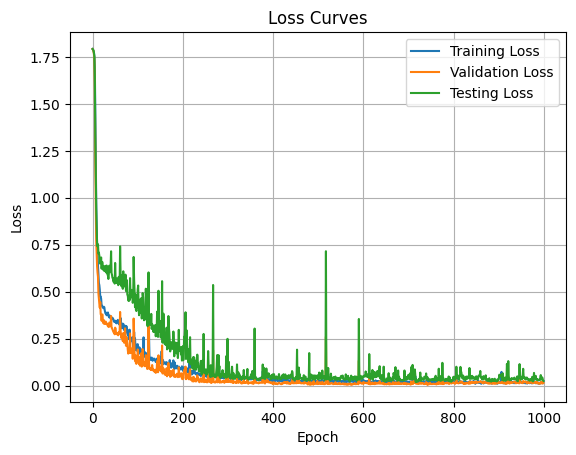

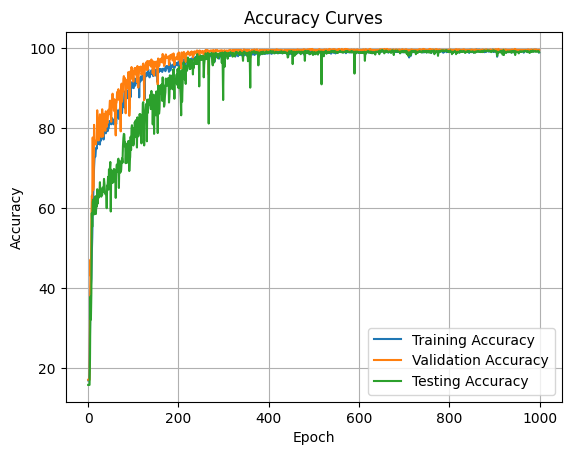

In [37]:
# Plot loss and accuracy curves for training, validation, and testing sets
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.plot(range(num_epochs), test_losses, label='Testing Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(range(num_epochs), train_accs, label='Training Accuracy')
plt.plot(range(num_epochs), val_accs, label='Validation Accuracy')
plt.plot(range(num_epochs), test_accs, label='Testing Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


In [38]:
# Close the writer
writer.close()

# Save the model
torch.save(model.state_dict(), 'lightweight_net_color_orientation_v3.pth')